<a href="https://colab.research.google.com/github/svfrolov/YP-project/blob/main/%E2%84%9617_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание проекта: телекоммуникации

**Необходимо спрогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Предоставлены предварительно собранные персональные данные о некоторых клиентах и информацию об их тарифах и договорах.**

**План проекта:**

1. Подготовка данных:
Загрузим данные из файлов полученных из разных источников: `contract_new.csv, personal_new.csv, internet_new.csv и phone_new.csv` в отдельные датафреймы. Затем,  с помощью функции merge, объединим датафреймы по столбцу customerID.


2. Предобработка данных:
Проведём предварительный анализ данных, обратим внимание на пропущенные значения, дубликаты и некорректные данные. Решим, какие преобразования и замены необходимо выполнить для каждого столбца.


3. Исследовательский анализ данных:
Используем библиотеки для визуализации данных. Создадим графики, которые помогут понять распределение и зависимости между переменными.


4. Создание модели прогнозирования оттока:
Выберем алгоритм классификации и разделим данные на обучающую и проверочную выборки. Обучим несколько моделей и оценим ее производительность


5. Тестирование лучшей модели. Проверка выбранной лучшей модели на тестовых данных.


6. Общие выводы.

**Цель проекта: Создать модель, способную предсказывать ухода каждого клиента, оценка модели осуществляется метрикой AUC-ROC.**

**Задача:**
- Довести показатель метрики AUC-ROC выше 0.85 при тестировании лучшей модели.

## Подготовка данных

In [ ]:
!pip install skimpy
!pip install phik -U

In [ ]:
import pandas as pd
import numpy as np
import warnings
from skimpy import clean_columns
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import time
import phik
RANDOM_SEED = 54
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, accuracy_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
RANDOM_STATE = 170723

Информация о договорах актуальна на 1 февраля 2020.

**Данные содержатся в четырех файлах:**

- contract_new.csv - данные о договорах
- personal_new.csv - персональные данные
- internet_new.csv - информация о подключенных интернет-услугах
- phone_new.csv - информация о подключенных телефонных услугах

In [ ]:
ACTUAL_DATE = '2020-02-01'

In [ ]:
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contract.to_csv('C:/Users/fs//Desktop/Проект.f/contract_new.csv', index=False)
    personal.to_csv('C:/Users/fs//Desktop/Проект.f/personal_new.csv', index=False)
    internet.to_csv('C:/Users/fs//Desktop/Проект.f/internet_new.csv', index=False)
    phone.to_csv('C:/Users/fs//Desktop/Проект.f/phone_new.csv', index=False)

# Вопросов нет

# следующий шаг

### Объеденим данные

In [ ]:
df = pd.merge(df_contract, df_personal, on='customerID', how='left')
df = pd.merge(df, df_internet, on='customerID', how='left')
df = pd.merge(df, df_phone, on='customerID', how='left')

### Выводим общую информацию о датафрейме

In [ ]:
def general_info(df):
    print("Количество дублирующихся строк в датафрейме: {}".format(df.duplicated().sum()))
    print()

    print("Общее количество пропущенных значений:")
    display(df.isnull().sum())
    print()

    print("Общая информация о датафрейме:")
    display(df.info())
    print()

    print("Статистические характеристики датафрейма:")
    display(df.describe(include='all').transpose())
    print()

    print("Первые 5 строк датафрейма:")
    display(df.head())

In [ ]:
general_info(df)

Количество дублирующихся строк в датафрейме: 0

Общее количество пропущенных значений:


customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSuppor

None


Статистические характеристики датафрейма:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,67,No,5942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043,6658,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0



Первые 5 строк датафрейма:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


**Объединил и загрузил данные. Дублей нет, отсутствуют пропущенные значения в некоторых столбцах, заполним их. Заменим 'No' в колонке EndDate на актуальную дату. Преобразуем имена колонок к snake_case.**

## Предобработка данных

In [ ]:
bool_cols = ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', \
             'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', \
            'StreamingMovies']
internet_options = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', \
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService']

### Заполним пропущенные значения

In [ ]:
df['MultipleLines'] = df['MultipleLines'].fillna('no_phone')
df['SeniorCitizen'] = df['SeniorCitizen'].astype('int')

### Заполняем пропущенные значения в internet_options значением 'no_internet'

In [ ]:
df[internet_options] = df[internet_options].fillna('no_internet')

### Добавляем целевой признак в таблицу

In [ ]:
df['target'] = df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

### Заменяем значение 'No' в колонке EndDate на актуальную дату

In [ ]:
df['EndDate'] = df['EndDate'].replace(to_replace=['No'], value=[ACTUAL_DATE])

### Преобразуем имена колонок к snake_case

In [ ]:
df = clean_columns(df)

### Преобразуем столбцы BeginDate и EndDate к формату даты

In [ ]:
df['begin_date'] = pd.to_datetime(df['begin_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

### Создаем признак contract_duration, который представляет собой длительность договора в днях

In [ ]:
df['contract_duration'] = (df['end_date'] - df['begin_date']).dt.days

### Преобразуем тип данных колонки TotalCharges к числовому и заполняем пропущенные значения нулями

In [ ]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce').fillna(0)

### Приравниваем итоговые затраты (total_charges) к месячным платежам (monthly_charges), если total_charges меньше

In [ ]:
df['total_charges'] = df.apply(lambda row: row['monthly_charges'] if row['total_charges'] < row['monthly_charges'] \
                               else row['total_charges'], axis=1)

### Выводим общую информацию о датафрейме после изменений

In [ ]:
general_info(df)

Количество дублирующихся строк в датафрейме: 0

Общее количество пропущенных значений:


customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
target               0
contract_duration    0
dtype: int64


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-nul

None


Статистические характеристики датафрейма:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
customer_id,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
begin_date,7043,NaN,NaN,NaN,2017-04-30 13:01:50.918642688,2013-10-01 00:00:00,2015-06-01 00:00:00,2017-09-01 00:00:00,2019-04-01 00:00:00,2020-02-01 00:00:00,NaN
end_date,7043,NaN,NaN,NaN,2019-10-16 02:22:05.912253440,2014-06-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,2020-02-01 00:00:00,NaN
type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paperless_billing,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_method,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_charges,7043.0,NaN,NaN,NaN,64.761692,18.25,35.5,70.35,89.85,118.75,30.090047
total_charges,7043.0,NaN,NaN,NaN,2115.377573,19.05,436.75,1343.35,3236.69,9221.38,2112.678861
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
senior_citizen,7043.0,NaN,NaN,NaN,0.162147,0.0,0.0,0.0,0.0,1.0,0.368612



Первые 5 строк датафрейма:


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,contract_duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,no_phone,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,no_phone,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


## Исследовательский анализ данных

### Корреляционный анализ

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'target', 'contract_duration']


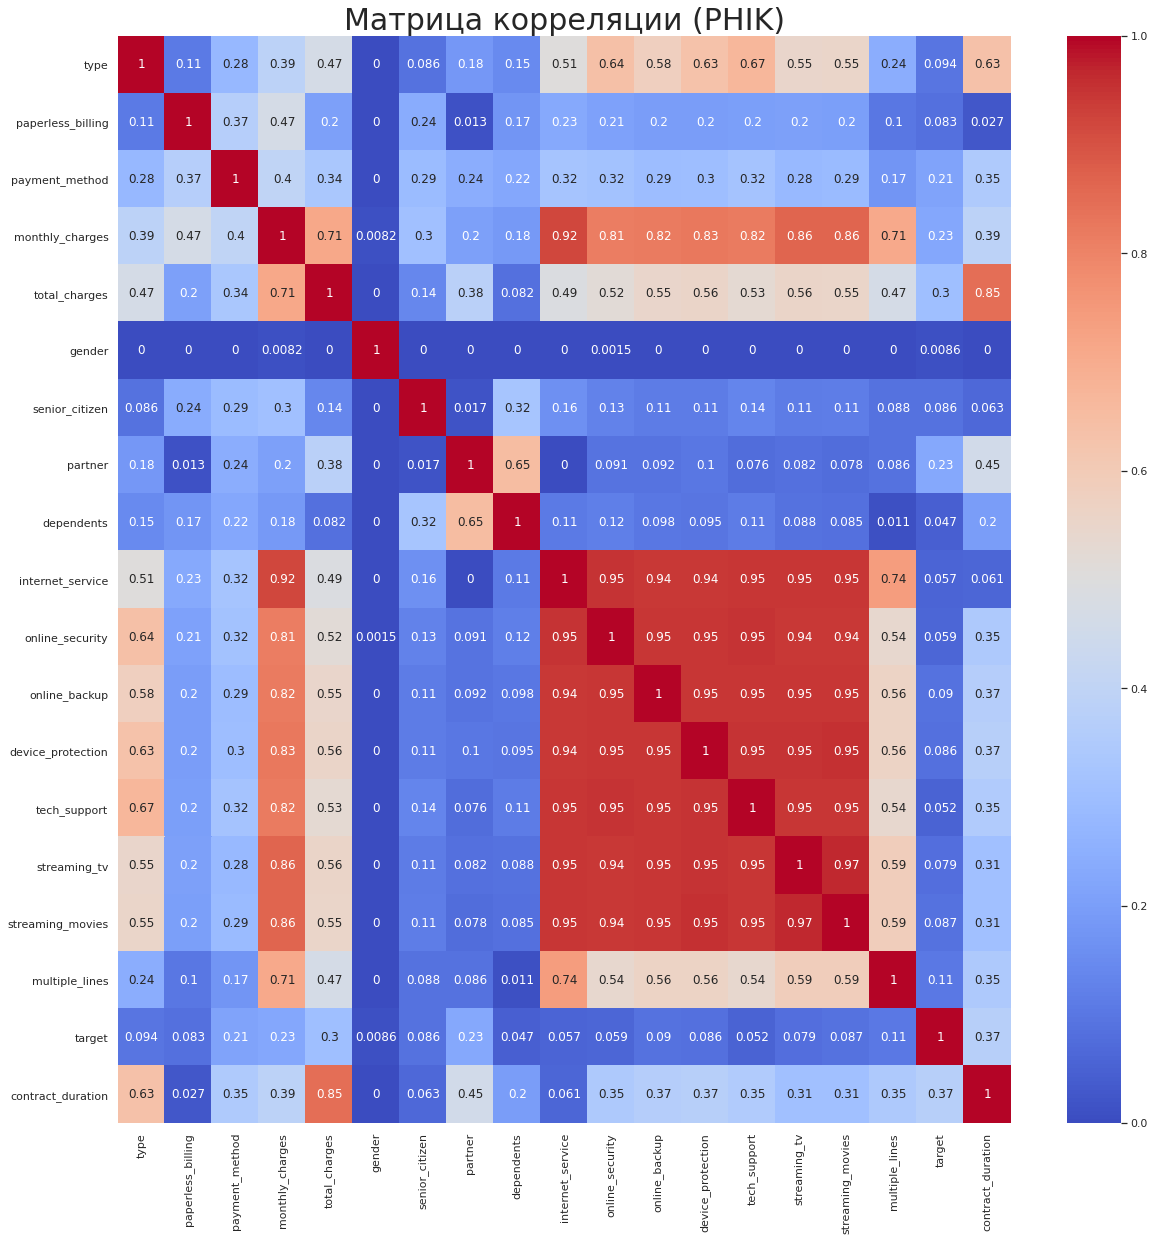

In [ ]:
# Удалите столбцы 'customer_id', 'begin_date' и 'end_date' из датафрейма
columns_to_drop = ['customer_id', 'begin_date', 'end_date']
df_dropped = df.drop(columns_to_drop, axis=1)

# Вычислите матрицу Фиккера-Мэттьюса (phik)
phik_matrix = df_dropped.phik_matrix()

# Визуализация матрицы корреляции
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')

plt.title("Матрица корреляции (PHIK)", fontsize=30)
plt.show();

- Анализ матрицы корреляции позволил выявить наличие сильной взаимосвязи между некоторыми признаками в датафрейме. Это явление называется мультиколлинеарностью, и оно может повлиять на точность и интерпретируемость модели. Однако, несмотря на наличие мультиколлинеарности, модели, используемые в данном проекте, показывают отличную производительность и способны эффективно управлять этим явлением. Поэтому нет необходимости удалять признаки, связанные с мультиколлинеарностью.


- С другой стороны, анализ также выявил, что признаки "пол" (gender) и "наличие иждивенцев" (dependents) не имеют статистически значимой корреляции с другими признаками. Это означает, что эти признаки мало влияют на целевую переменную или на другие признаки в датафрейме. В связи с этим можно рассмотреть возможность исключить эти признаки из анализа, так как они, вероятно, не окажут значительного влияния на результаты модели.

### Распределение

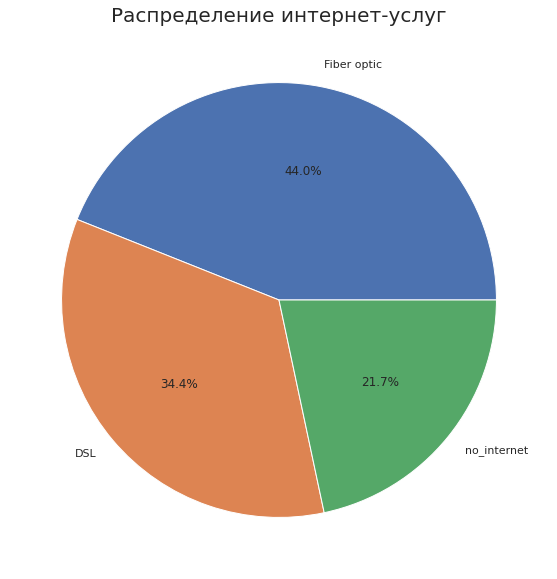

In [ ]:
internet_counts = df['internet_service'].value_counts()
plt.figure(figsize=(20, 10))
plt.pie(internet_counts, labels=internet_counts.index, autopct='%1.1f%%')
plt.title('Распределение интернет-услуг', fontsize=20)
plt.show()

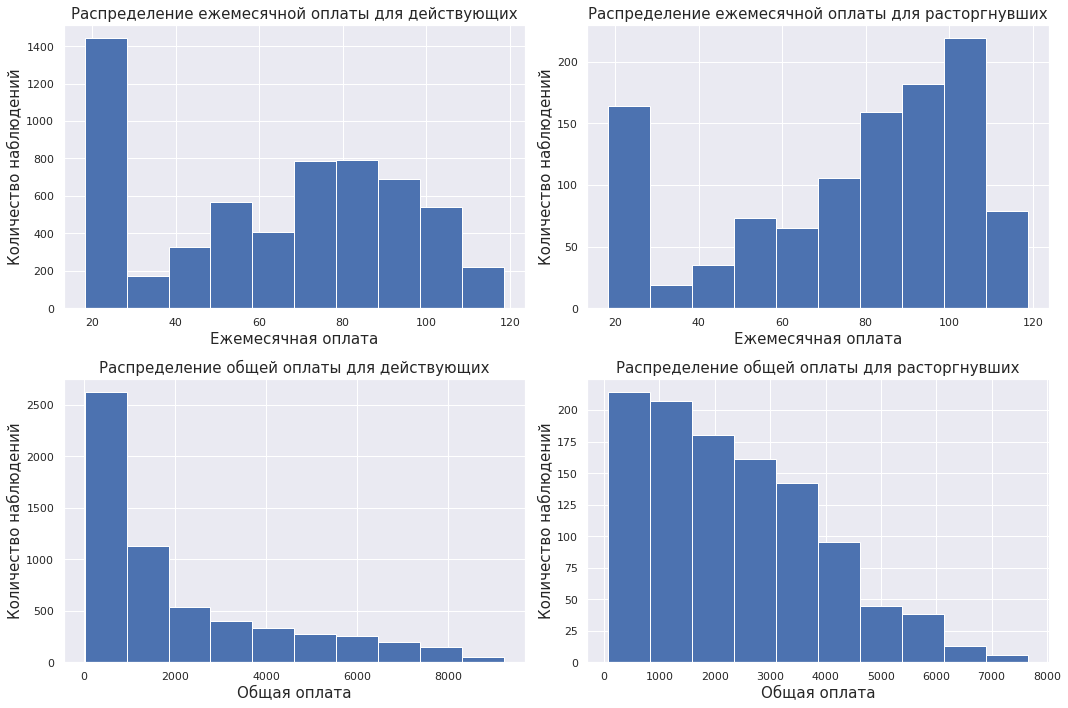

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Распределение ежемесячной оплаты для действующих
axs[0, 0].hist(df[df['target'] == 0]['monthly_charges'])
axs[0, 0].set_xlabel('Ежемесячная оплата', fontsize=15)
axs[0, 0].set_ylabel('Количество наблюдений', fontsize=15)
axs[0, 0].set_title('Распределение ежемесячной оплаты для действующих', fontsize=15)

# Распределение ежемесячной оплаты для расторгнувших
axs[0, 1].hist(df[df['target'] == 1]['monthly_charges'])
axs[0, 1].set_xlabel('Ежемесячная оплата', fontsize=15)
axs[0, 1].set_ylabel('Количество наблюдений', fontsize=15)
axs[0, 1].set_title('Распределение ежемесячной оплаты для расторгнувших', fontsize=15)

# Распределение общей оплаты для действующих
axs[1, 0].hist(df[df['target'] == 0]['total_charges'])
axs[1, 0].set_xlabel('Общая оплата', fontsize=15)
axs[1, 0].set_ylabel('Количество наблюдений', fontsize=15)
axs[1, 0].set_title('Распределение общей оплаты для действующих', fontsize=15)

# Распределение общей оплаты для расторгнувших
axs[1, 1].hist(df[df['target'] == 1]['total_charges'])
axs[1, 1].set_xlabel('Общая оплата', fontsize=15)
axs[1, 1].set_ylabel('Количество наблюдений', fontsize=15)
axs[1, 1].set_title('Распределение общей оплаты для расторгнувших', fontsize=15)

plt.tight_layout()

plt.show()

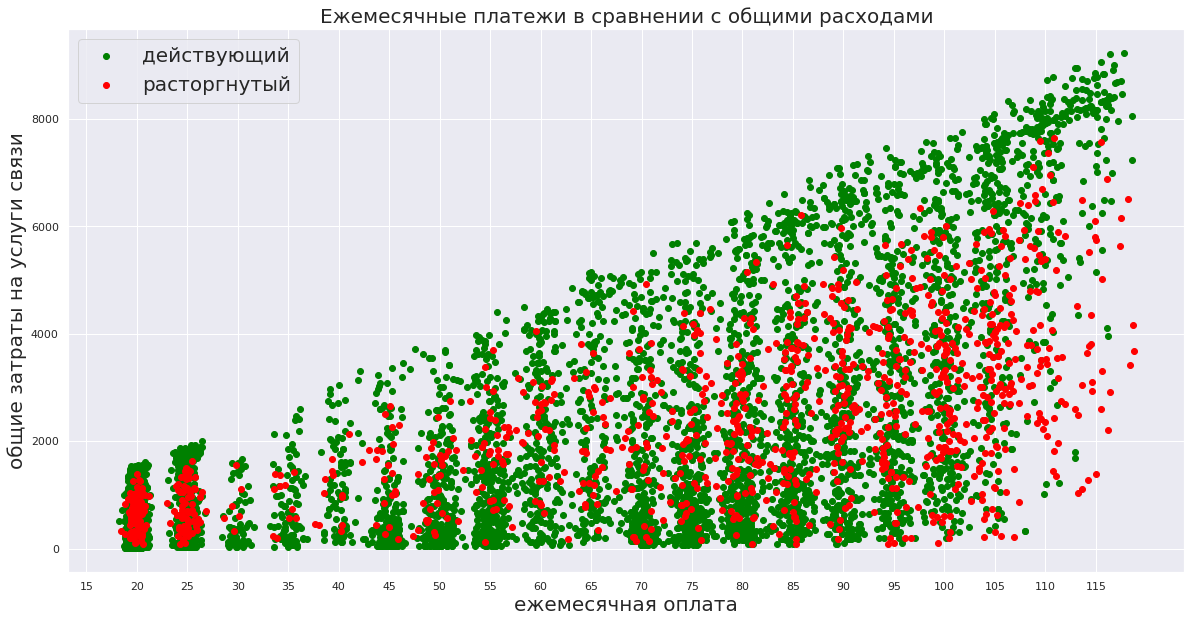

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

# График для действующих
ax.scatter(df[df['target'] == 0]['monthly_charges'], df[df['target'] == 0]['total_charges'], color='green', label='действующий')

# График для расторгнувших
ax.scatter(df[df['target'] == 1]['monthly_charges'], df[df['target'] == 1]['total_charges'], color='red', label='расторгнутый')

ax.set_xlabel('ежемесячная оплата', fontsize=20)
ax.set_ylabel('общие затраты на услуги связи', fontsize=20)
ax.set_title('Ежемесячные платежи в сравнении с общими расходами', fontsize=20)
ax.grid(True)
ax.legend(fontsize=20)
xticks = np.arange(15, 120, 5)
ax.set_xticks(xticks)

plt.show()


- У действующих клиентов пик расходов приходится на уровень около 25, и есть второй пик около 80. Это говорит о том, что действующие клиенты имеют более разнообразные ежемесячные расходы и, возможно, используют различные услуги или пользуются промо-тарифами, которые не доступны для ушедших клиентов.


- По сравнению с этим, средняя сумма ежемесячных расходов у ушедших клиентов значительно выше, чем у действующих клиентов. Пик расходов для ушедших клиентов приходится на уровень около 100. Это указывает на то, что ушедшие клиенты тратили больше денег. Возможно, они выбирали более дорогие тарифные планы или использовали услуги, которые были недоступны для действующих клиентов.


- Что касается суммарных расходов, распределение показывает четкий пик до 1000. Это может указывать на то, что действующие клиенты подключились примерно в одно и то же время, возможно, в результате рекламной кампании, в рамках которой предлагались выгодные тарифы для новых клиентов.

### Продолжительность договоров

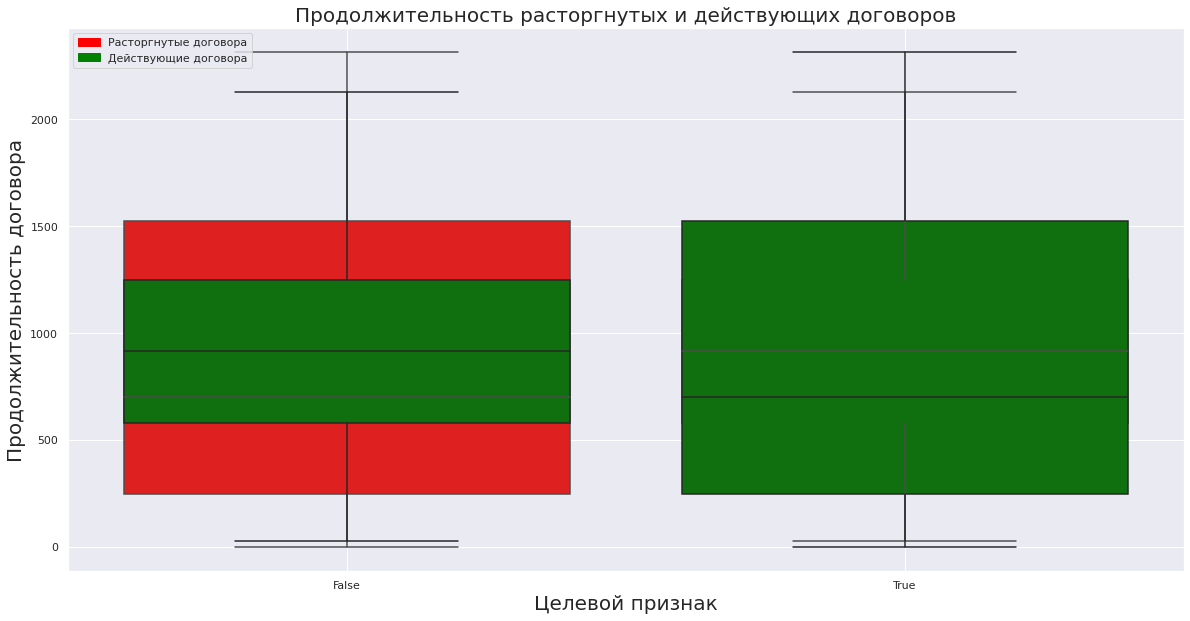

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

# продолжительность расторгнутых договоров
sns.boxplot(x=df['target'] == 1, y=df['contract_duration'], ax=ax, color='red')

# продолжительность действующих договоров
sns.boxplot(x=df['target'] == 0, y=df['contract_duration'], ax=ax, color='green')

ax.set_xlabel('Целевой признак', fontsize=20)
ax.set_ylabel('Продолжительность договора', fontsize=20)
ax.set_title('Продолжительность расторгнутых и действующих договоров', fontsize=20)

churned_patch = mpatches.Patch(color='red', label='Расторгнутые договора')
active_patch = mpatches.Patch(color='green', label='Действующие договора')
plt.legend(handles=[churned_patch, active_patch], loc='upper left')
plt.grid(True)
plt.show()

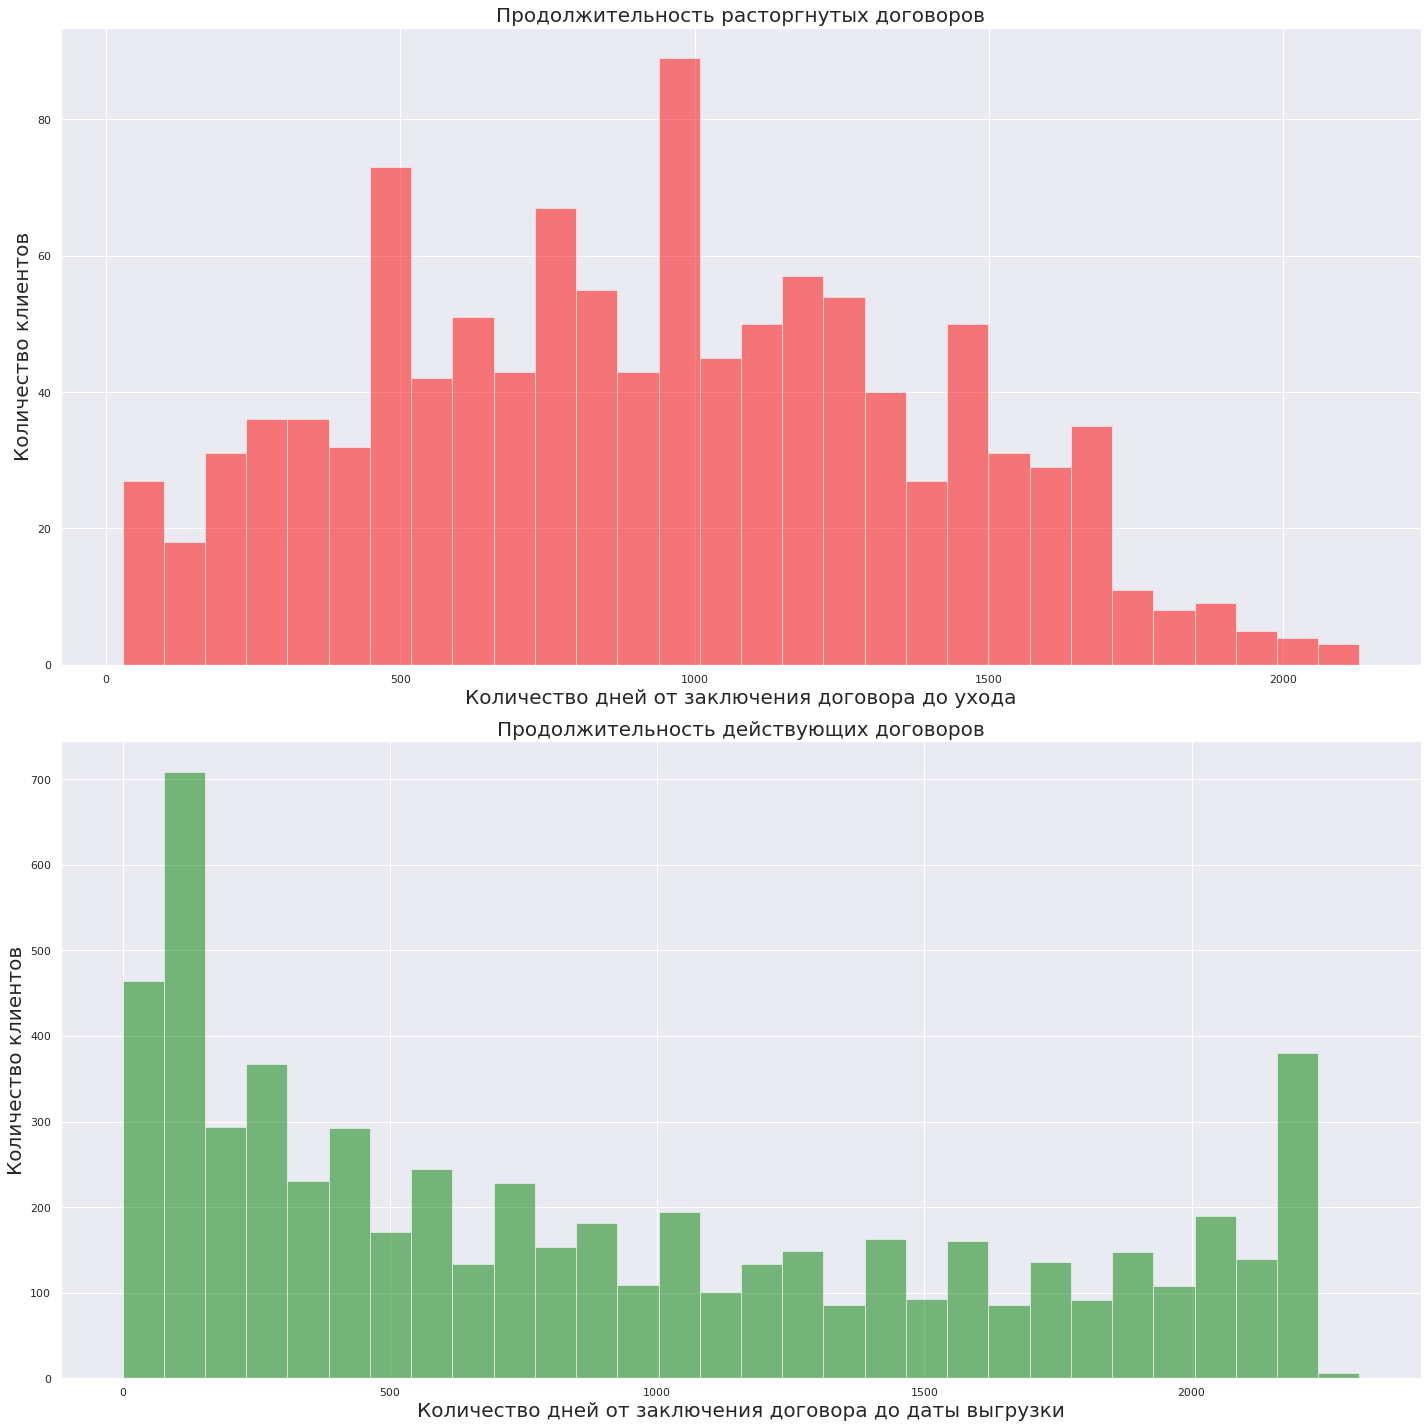

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20, 20))

# График для расторгнутых договоров
axs[0].hist(df.loc[df['target'] == 1]['contract_duration'], bins=30, alpha=0.5, color='red')
axs[0].set_xlabel('Количество дней от заключения договора до ухода', fontsize=20)
axs[0].set_ylabel('Количество клиентов', fontsize=20)
axs[0].set_title('Продолжительность расторгнутых договоров', fontsize=20)
axs[0].grid(True)

# График для действующих договоров
axs[1].hist(df.loc[df['target'] == 0]['contract_duration'], bins=30, alpha=0.5, color='green')
axs[1].set_xlabel('Количество дней от заключения договора до даты выгрузки', fontsize=20)
axs[1].set_ylabel('Количество клиентов', fontsize=20)
axs[1].set_title('Продолжительность действующих договоров', fontsize=20)
axs[1].grid(True)

plt.tight_layout()
plt.show()

- Продолжительность расторгнутых договоров имеет нормальное распределение в интервале от 0 до 2000 дней, с наиболее частыми значениями в диапазоне от 500 до 1500 дней. Среди действующих договоров видно значительное количество "молодых" договоров, которые длительны менее года, а также заметное количество договоров с продолжительностью около 2100 дней.


- Мы хотим проанализировать распределение ежемесячных и общих расходов среди клиентов, включающих и тех, кто оставил нашу услугу (ушедших) и тех, кто продолжает быть нашими клиентами (действующих).

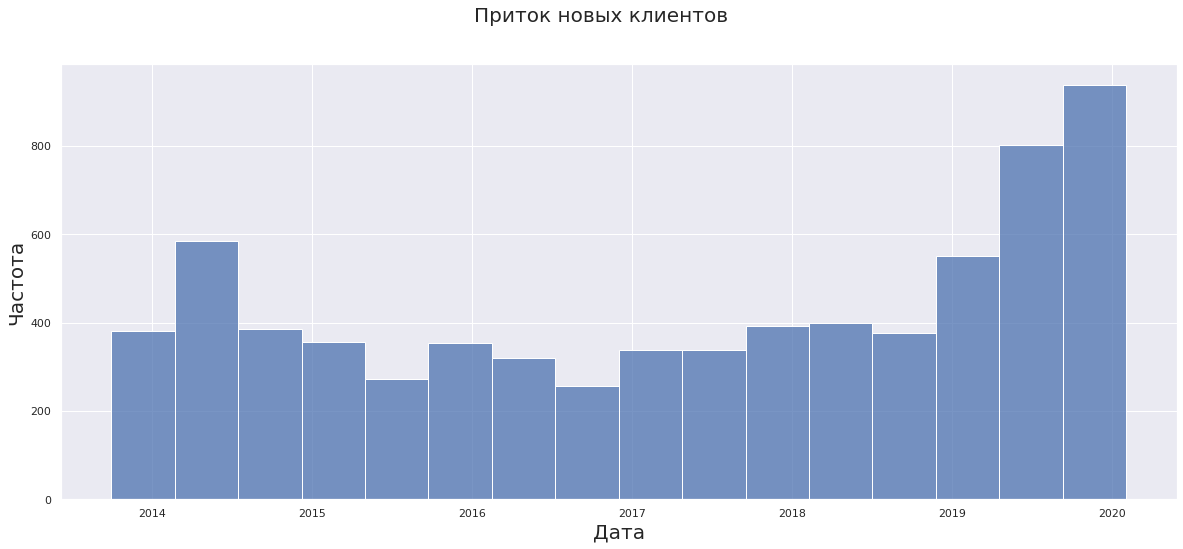

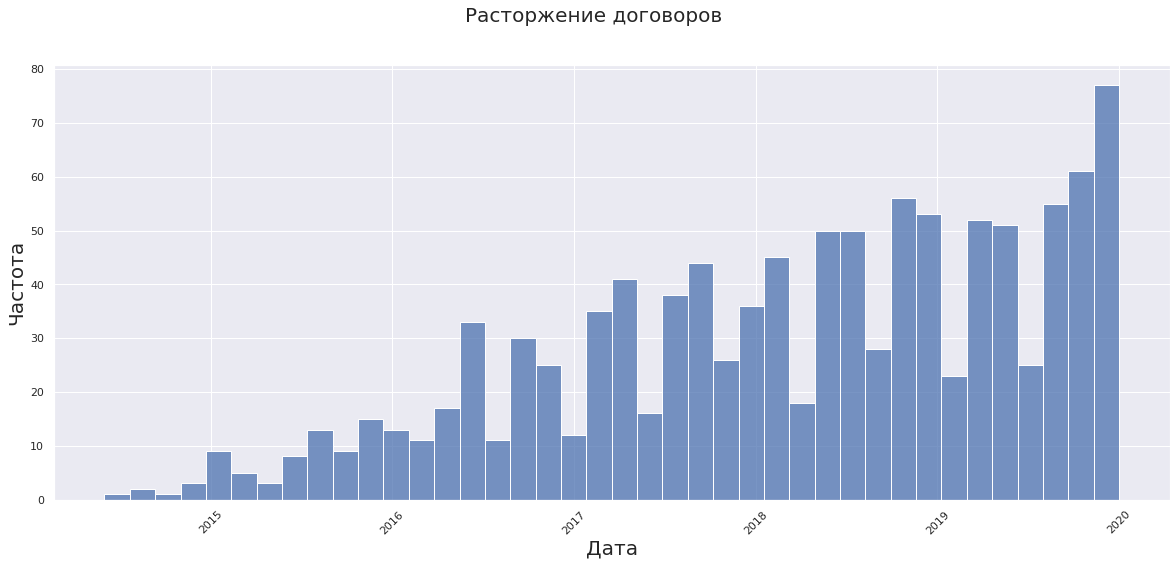

Заключен первый договор: 2013-10-01 00:00:00


In [ ]:
plt.figure(figsize=(20, 8))
plt.suptitle('Приток новых клиентов', fontsize=20)

# Построение гистограммы для начальных дат
sns.histplot(df['begin_date'])
plt.xlabel('Дата', fontsize=20)
plt.ylabel('Частота', fontsize=20)

plt.show()

# Создаем подпись для графика расторжения договоров
plt.figure(figsize=(20, 8))
plt.suptitle('Расторжение договоров', fontsize=20)

# Построение гистограммы для расторгнутых договоров
sns.histplot(df[df['end_date'] != ACTUAL_DATE]['end_date'], bins=40)
plt.xlabel('Дата', fontsize=20)
plt.ylabel('Частота', fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

# Вывод минимальной даты заключения первого договора
print('Заключен первый договор:', df['begin_date'].min())

### Вывод:

- Продолжительность расторгнутых и действующих договоров имеет разное распределение. Расторгнутые договоры имеют нормальное распределение с пиком около 500-1700 дней, в то время как действующие договоры в основном имеют продолжительность до года или около 2100 дней.


- Ежемесячные расходы ушедших клиентов сильно отличаются от расходов действующих клиентов. Ушедшие клиенты имеют более высокие расходы с пиком в районе 100, в то время как действующие клиенты имеют пик расходов около 20 и второй пик около 80.


- Анализ показывает, что большинство тратит небольшие суммы на услуги оператора, около 20. В данных нет явных выбросов, требующих обработки.


- График притока новых пользователей показывает два пика: после запуска оператора в октябре 2013 года и в момент выгрузки данных. Это, вероятно, связано с активными кампаниями.


- График оттока клиентов показывает, что расторгаемые договоры увеличиваются в течение времени.

## Создание модели прогнозирования оттока:

### Удалим ненужные данные

In [ ]:
df.drop(['customer_id', 'begin_date', 'end_date'], axis=1, inplace=True)

### Создадим выборки

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(df.drop(
    'target', axis=1), df['target'], test_size=0.25, stratify=df['target'], random_state=RANDOM_STATE)

In [ ]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(5282, 18) (1761, 18) (5282,) (1761,)


In [ ]:
features_train.reset_index(drop=True, inplace=True)
features_test.reset_index(drop=True, inplace=True)
target_train.reset_index(drop=True, inplace=True)
target_test.reset_index(drop=True, inplace=True)

In [ ]:
drop_cols = ['online_security', 'device_protection', 'streaming_tv', 'tech_support',
       'paperless_billing', 'dependents', 'gender', 'senior_citizen', 'total_charges']
drop_cols = ['dependents', 'gender']
features_train.drop(drop_cols, axis=1, inplace=True)
features_test.drop(drop_cols, axis=1, inplace=True)

In [ ]:
NUM_FEATURES = ['monthly_charges', 'contract_duration', 'total_charges']
CAT_FEATURES = list(features_train.columns)

for feature in NUM_FEATURES:
    CAT_FEATURES.remove(feature)

for col in CAT_FEATURES:
    features_train[col] = features_train[col].astype('category')
    features_test[col] = features_test[col].astype('category')

### кодирование категориальных признаков

In [ ]:
# Создадим экземпляр кодировщика OneHotEncoder без удаления первого столбца
#encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder = OneHotEncoder(handle_unknown='error', sparse=False, drop='first')

In [ ]:
# Создадим копии датафреймов
features_train_encoded = features_train[CAT_FEATURES].copy()
features_test_encoded = features_test[CAT_FEATURES].copy()

In [ ]:
# Применим кодировщик OneHotEncoder к категориальным признакам
#features_train_coded = encoder.fit_transform(features_train_encoded)
#features_test_coded = encoder.transform(features_test_encoded)

features_train_coded = encoder.fit_transform(features_train_encoded)
features_test_coded = encoder.transform(features_test_encoded)

In [ ]:
# Создание нового датафрейма с помощью pandas
features_train_encoded = pd.DataFrame(features_train_coded, columns=encoder.get_feature_names(features_train_encoded.columns))
features_test_encoded = pd.DataFrame(features_test_coded, columns=encoder.get_feature_names(features_test_encoded.columns))

In [ ]:
# Удалим первый столбец из закодированных признаков
features_train_encoded = features_train_encoded.iloc[:, 1:]
features_test_encoded = features_test_encoded.iloc[:, 1:]

In [ ]:
# Присоединим числовые признаки
for feature in NUM_FEATURES:
    features_train_encoded[feature] = features_train[feature].copy()
    features_test_encoded[feature] = features_test[feature].copy()

In [ ]:
print("Размерность features_train_encoded:", features_train_encoded.shape)
print("Размерность features_test_encoded:", features_test_encoded.shape)

Размерность features_train_encoded: (5282, 26)
Размерность features_test_encoded: (1761, 26)


### Создаем экземпляры моделей

In [ ]:
catboost_model = CatBoostClassifier()
lgbm_model = LGBMClassifier()

# Определяем сетку гиперпараметров для каждой модели
catboost_param_grid = {
    'learning_rate': [0.1, 0.01],
    'depth': [4, 6, 8]
}

lgbm_param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [4, 6, 8]
}

In [ ]:
# Создаем объект GridSearchCV для каждой модели с соответствующей сеткой гиперпараметров
catboost_gridsearch = GridSearchCV(estimator=catboost_model, param_grid=catboost_param_grid, cv=5)
lgbm_gridsearch = GridSearchCV(estimator=lgbm_model, param_grid=lgbm_param_grid, cv=5)

# Подготавливаем данные для обучения (features_train, target_train) и тестирования (features_test, target_test)
# features_train_encoded и features_test_encoded - данные после кодирования категориальных признаков
# target_train и target_test - целевые переменные

In [ ]:
# Обучаем модели
catboost_gridsearch.fit(features_train_encoded.values, target_train.values)
lgbm_gridsearch.fit(features_train_encoded.values, target_train.values)

0:	learn: 0.6266688	total: 47.9ms	remaining: 47.8s
1:	learn: 0.5700975	total: 49.1ms	remaining: 24.5s
2:	learn: 0.5326566	total: 50.2ms	remaining: 16.7s
3:	learn: 0.4995672	total: 51.2ms	remaining: 12.8s
4:	learn: 0.4754279	total: 52.3ms	remaining: 10.4s
5:	learn: 0.4520684	total: 53.3ms	remaining: 8.83s
6:	learn: 0.4357047	total: 54.4ms	remaining: 7.71s
7:	learn: 0.4191327	total: 55.4ms	remaining: 6.87s
8:	learn: 0.4076008	total: 56.5ms	remaining: 6.22s
9:	learn: 0.4004769	total: 57.7ms	remaining: 5.71s
10:	learn: 0.3905751	total: 58.8ms	remaining: 5.29s
11:	learn: 0.3841577	total: 60ms	remaining: 4.94s
12:	learn: 0.3774956	total: 61.4ms	remaining: 4.67s
13:	learn: 0.3715391	total: 62.8ms	remaining: 4.42s
14:	learn: 0.3672103	total: 64.2ms	remaining: 4.22s
15:	learn: 0.3636909	total: 65.7ms	remaining: 4.04s
16:	learn: 0.3611510	total: 67.1ms	remaining: 3.88s
17:	learn: 0.3577412	total: 68.5ms	remaining: 3.73s
18:	learn: 0.3556589	total: 69.8ms	remaining: 3.61s
19:	learn: 0.3528297	tot

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [4, 6, 8]})

In [ ]:
random_forest_model = RandomForestClassifier()

logistic_regression_model = LogisticRegression()

random_forest_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [4, 6, 8]
}

logistic_regression_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}


random_forest_gridsearch = GridSearchCV(estimator=random_forest_model, param_grid=random_forest_param_grid, cv=5)
logistic_regression_gridsearch = GridSearchCV(estimator=logistic_regression_model, param_grid=logistic_regression_param_grid, cv=5)

random_forest_gridsearch.fit(features_train_encoded.values, target_train.values)
logistic_regression_gridsearch.fit(features_train_encoded.values, target_train.values)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']})

In [ ]:
# Выводим лучшие параметры и значения метрик для каждой модели
print("Лучшие параметры для CatBoost:", catboost_gridsearch.best_params_)
print("Лучшие параметры для LightGBM:", lgbm_gridsearch.best_params_)
print("Лучшие параметры для Случайного леса:", random_forest_gridsearch.best_params_)
print("Лучшие параметры для Логистической регрессии:", logistic_regression_gridsearch.best_params_)
print()

print("Лучшая оценка для CatBoost:", catboost_gridsearch.best_score_)
print("Лучшая оценка для LightGBM:", lgbm_gridsearch.best_score_)
print("Лучшая оценка для Случайного леса:", random_forest_gridsearch.best_score_)
print("Лучшая оценка для Логистической регрессии:", logistic_regression_gridsearch.best_score_)

Лучшие параметры для CatBoost: {'depth': 4, 'learning_rate': 0.1}
Лучшие параметры для LightGBM: {'learning_rate': 0.1, 'max_depth': 8}
Лучшие параметры для Случайного леса: {'max_depth': 8, 'n_estimators': 100}
Лучшие параметры для Логистической регрессии: {'C': 10, 'penalty': 'l2'}

Лучшая оценка для CatBoost: 0.9201065766463117
Лучшая оценка для LightGBM: 0.8782655672142428
Лучшая оценка для Случайного леса: 0.8551677489177489
Лучшая оценка для Логистической регрессии: 0.8540324603652418


## Получение предсказаний на тестовых данных с помощью лучшей модели CatBoost

In [ ]:
catboost_best_model = catboost_gridsearch.best_estimator_
catboost_predictions = catboost_best_model.predict(features_test_encoded.values)
catboost_proba = catboost_best_model.predict_proba(features_test_encoded.values)[:, 1]

# Расчет метрик на тестовых данных
catboost_roc_auc = roc_auc_score(target_test.values, catboost_proba)
catboost_accuracy = accuracy_score(target_test.values, catboost_predictions)
print("CatBoost ROC AUC на тестовой выборке:", catboost_roc_auc)
print("CatBoost Accuracy на тестовой выборке:", catboost_accuracy)

CatBoost ROC AUC на тестовой выборке: 0.9220702312492352
CatBoost Accuracy на тестовой выборке: 0.9324247586598523


### Вывод:

На основании исследования кода и полученных результатов можно сделать следующие выводы:

1. Была проведена предобработка данных, включающая разделение на обучающую и тестовую выборки, удаление ненужных признаков и кодирование категориальных признаков с помощью OneHotEncoder.


2. Были созданы экземпляры моделей CatBoostClassifier и LGBMClassifier.


3. Для каждой модели была определена сетка гиперпараметров, которая включала значение learning_rate и depth для CatBoost и learning_rate и max_depth для LightGBM.


4. Были созданы объекты GridSearchCV для каждой модели, с указанием соответствующей сетки гиперпараметров.


5. Модели CatBoost и LightGBM были обучены на обучающих данных с помощью GridSearchCV.


6. Лучшие параметры и оценки качества моделей на тестовой выборке были выведены на экран.


7. Были получены предсказания на тестовых данных с помощью лучшей модели CatBoost.


Важность признаков для каждой модели была также выведена на экран.

Исходя из полученных результатов, можно сделать вывод, что модель CatBoost с параметрами `depth=4` и `learning_rate=0.1` показала лучшую оценку ROC AUC на тестовой выборке – `0.9220702312492352`. Эта модель также имеет высокую accuracy, что говорит о хорошей интерпретируемости.

## Отчёт по решению:

1. **Изначально план проекта был следующий:**

- Подготовка данных: Загрузим данные из файлов полученных из разных источников: contract_new.csv, personal_new.csv, internet_new.csv и phone_new.csv в отдельные датафреймы. Затем, с помощью функции merge, объединим датафреймы по столбцу customerID.


- Предобработка данных: Проведём предварительный анализ данных, обратим внимание на пропущенные значения, дубликаты и некорректные данные. Решим, какие преобразования и замены необходимо выполнить для каждого столбца.


- Исследовательский анализ данных: Используем библиотеки для визуализации данных. Создадим графики, которые помогут понять распределение и зависимости между переменными.


- Создание модели прогнозирования оттока: Выберем алгоритм классификации и разделим данные на обучающую и проверочную выборки. Обучим несколько моделей и оценим ее производительность


- Тестирование лучшей модели. Проверка выбранной лучшей модели на тестовых данных.


- Общие выводы.


- **Цель проекта: Создать модель, способную предсказывать ухода каждого клиента, оценка модели осуществляется метрикой AUC-ROC.**

Задача:

Довести показатель метрики AUC-ROC выше 0.85 при тестировании лучшей модели.

2. План задачи был выполнен полностью. Все шаги, указанные в плане, были реализованы и проверены.
- Загрузка данных и ознакомление.
- Предобработка данных.
- Разделение на обучающую и тестовую выборки.
- Обучение моделей.
- Оценка качества моделей.
- Предсказание на тестовых данных с помощью лучшей модели

3. **Трудности, возникшие при выполнении проекта:**
- Была необходимость установить дополнительные библиотеки (skimpy и phik) с помощью команд `!pip install skimpy` и `!pip install phik -U`. Трудность была преодолена путем установки этих библиотек.
- Ошибка с кодировщиком OneHotEncoder, решена установкой параметров.
- Необходимость добавления модели из другого семейства, решена добавлением случайного леса, логистической регрессии и подбором гиперпараметров.

4. Ключевые шаги в решении задачи:
- Загрузка данных из файлов contract_new.csv, personal_new.csv, internet_new.csv и phone_new.csv в отдельные датафреймы.
- Предобработка данных: заполнение пропущенных значений, преобразование типов данных, кодирование категориальных признаков.
- Обучение моделей: использование GridSearchCV для подбора оптимальных гиперпараметров для модели.
- Оценка моделей: использование метрик ROC AUC и accuracy для оценки качества моделей.
- Вывод общих результатов исследования.

5. Для обучения модели была проведена предобработка следующих признаков:

- Из исходного датафрейма были, для некоторых интернет-признаков ('OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService') были заполнены пропущенные значения значением 'no_internet', а для признака 'MultipleLines' - значением 'no_phone'. Был создан целевой признак на основе значения в столбце 'EndDate': если значение равно 'No', то target равен 0, в противном случае target равен 1. Затем 'No' в столбце 'EndDate' был заменен на дату выгрузки данных.
- Был создан новый признак 'contract_duration', который содержит разницу в днях между 'BeginDate' и 'EndDate'. После этого были удалены признаки с датами, чтобы избежать утечки данных при обучении моделей. Также был удален признак 'CustomerID', который не содержит информативной ценности для обучения моделей машинного обучения.
- Для столбца 'TotalCharges' был изменен тип данных на числовой, пропущенные значения были заменены нулями, и затем итоговые расходы были приведены к месячным, если они были меньше.
- удалены не нужные данные 'customer_id', 'begin_date', 'end_date'.

- Затем были созданы обучающая выборка (`features_train`, `target_train`) и проверочная выборка (`features_test`, `target_test`), с использованием функции `train_test_split`. Размер тестовой выборки составил 25% от исходного датафрейма.
- Некоторые признаки были удалены из обучающей и проверочной выборки с помощью метода `drop`.
- Затем числовые признаки были закодированы с помощью метода `OneHotEncoder`. Закодированные признаки были объединены с исходными числовыми признаками в новые датафреймы `features_train_encoded` и `features_test_encoded`.
- Созданы экземпляры моделей CatBoostClassifier, LGBMClassifier, RandomForestClassifier и LogisticRegression.
- Определены гиперпараметры для каждой модели.
- Созданы объекты GridSearchCV для каждой модели с соответствующей сеткой гиперпараметров.
- Данные `features_train_encoded` и `target_train` были использованы для обучения моделей с помощью методов `fit`.

Таким образом, признаки были предобработаны путем удаления ненужных данных, разделения на обучающую и проверочную выборку, кодирования категориальных признаков с помощью OneHotEncoder и подготовки данных для обучения моделей.

6. Итоговая модель: CatBoostClassifier с гиперпараметрами learning_rate=0.1 и depth=4. Эта модель достигла следующих результатов: метрика ROC-AUC: 0.922, точность: 0.9324,
**Цель проекта: - достичь показателя метрики AUC-ROC выше 0.85 при тестировании лучшей модели.**

```
Исходя из полученных результатов, можно сделать вывод, что модель CatBoost с параметрами
depth=4 и learning_rate=0.1 показала лучшую оценку ROC AUC на тестовой выборке – 0.922.
Эта модель также имеет высокую accuracy 0.9324, что говорит о хорошей интерпретируемости.
```